In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path
from tqdm import tqdm

In [2]:
basedir = Path().absolute().parent.parent.parent / "outputs/240311b"

In [3]:
trial_data = {}
for pkl_path in tqdm(list(basedir.glob("plume_navigation_par_seed*.pkl"))):
    trial_id = int(pkl_path.stem.split("_")[-1].replace("seed", ""))
    mp4_path = pkl_path.with_suffix(".mp4")
    try:
        with open(pkl_path, "rb") as f:
            obs_hist = pickle.load(f)["obs_hist"]
    except Exception as e:
        print(f"Failed to load {pkl_path}: {e}")
        continue
    trial_data[trial_id] = [x["fly"][0, :2].copy() for x in obs_hist]

100%|██████████| 99/99 [04:28<00:00,  2.71s/it]


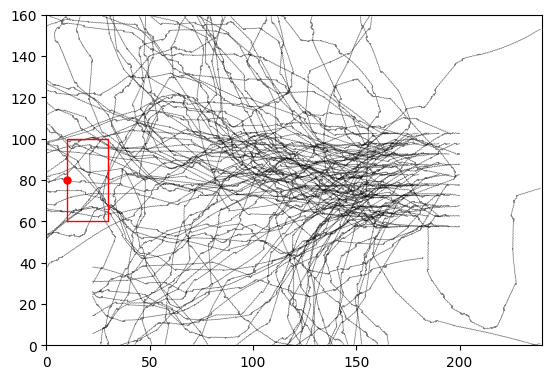

In [4]:
for trial, data in trial_data.items():
    xy = np.array(data)
    plt.plot(xy[:, 0], xy[:, 1], color="black", alpha=0.5, lw=0.5)
plt.plot([10], [80], color="red", marker="o", markersize=5)
plt.plot([10, 10, 30, 30, 10], [60, 100, 100, 60, 60], color="red", lw=1)
plt.xlim(0, 240)
plt.ylim(0, 160)
plt.gca().set_aspect("equal")

In [5]:
plume_path = Path(
    "/home/sibwang/Projects/flygym/outputs/complex_plume_0.2_0.2_1/plume.npz"
)
plume_data = np.load(plume_path)
plume_grid = plume_data["plume"].copy()
mean_plume_intensity = plume_grid.mean(axis=0)

In [ ]:
f_upper = lambda x: 0.15 * x + 85

Text(0, 0.5, 'y (mm)')

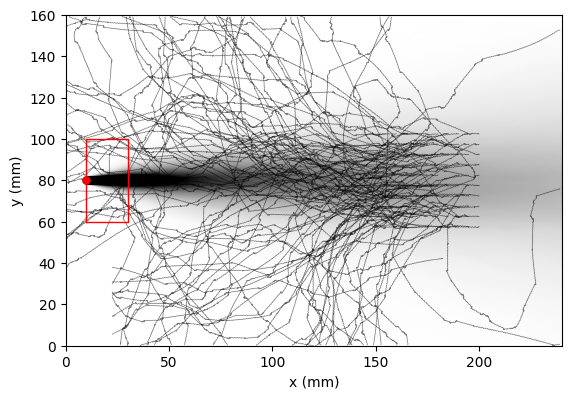

In [6]:
plt.imshow(
    mean_plume_intensity,
    extent=[0, 240, 0, 160],
    origin="lower",
    cmap="gray_r",
    vmin=0,
    vmax=0.2,
)
for trial, data in trial_data.items():
    xy = np.array(data)
    plt.plot(xy[:, 0], xy[:, 1], color="black", alpha=0.5, lw=0.5)
plt.plot([10], [80], color="red", marker="o", markersize=5)
plt.plot([10, 10, 30, 30, 10], [60, 100, 100, 60, 60], color="red", lw=1)
plt.xlim(0, 240)
plt.ylim(0, 160)
plt.gca().set_aspect("equal")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

In [7]:
dist_threshold = 10
termination_index_lookup = {}
for trial, data in trial_data.items():
    offset_from_source = np.array(data) - np.array(([10, 80]))
    dist_from_source = np.linalg.norm(offset_from_source, axis=1)
    if dist_from_source.min() < dist_threshold:
        term_index = np.argmin(dist_from_source)
        termination_index_lookup[trial] = term_index
    else:
        termination_index_lookup[trial] = None

In [8]:
len([idx for idx in termination_index_lookup.values() if idx is not None])

8

In [9]:
density_ts_lookup = {}
mean_densities_lookup = {}
for trial, data in tqdm(trial_data.items(), total=len(trial_data)):
    if termination_index_lookup[trial] is not None:
        data = data[: termination_index_lookup[trial]]
    row_col = (np.array(data) * 2).astype(int)
    density_ts = mean_plume_intensity[row_col[:, 1], row_col[:, 0]]
    density_ts_lookup[trial] = density_ts
    mean_densities_lookup[trial] = density_ts.mean()

100%|██████████| 99/99 [00:07<00:00, 13.56it/s]


[0.02418047, 0.0692154, 0.038425155, 0.015766056, 0.01942708, 0.04739414, 0.03270553, 0.0146148605, 0.0079564545, 0.036387987, 0.019318553, 0.024220256, 0.01915251, 0.033843745, 0.023966564, 0.009102585, 0.035153788, 0.022942668, 0.018558918, 0.02063787, 0.03273988, 0.008728404, 0.01298938, 0.04688137, 0.01879263, 0.018921483, 0.04467457, 0.030746885, 0.027115762, 0.02176285, 0.02558076, 0.023882462, 0.023127155, 0.027259037, 0.007148381, 0.039373614, 0.014053292, 0.015549716, 0.038278345, 0.021164922, 0.021231122, 0.0792007, 0.00899451, 0.14655295, 0.023813145, 0.027162608, 0.03113541, 0.024242967, 0.01706828, 0.0267171, 0.013552147, 0.10409701, 0.019615417, 0.008615292, 0.019610094, 0.012430574, 0.011104538, 0.0064367563, 0.036638796, 0.02832614, 0.04195724, 0.032480706, 0.020026555, 0.01873168, 0.027589034, 0.030026138, 0.024346689, 0.030945124, 0.0292397, 0.02200953, 0.040661022, 0.04276991, 0.027851362, 0.02914103, 0.021810068, 0.02484031, 0.06267898, 0.058987346, 0.06399532, 0.01

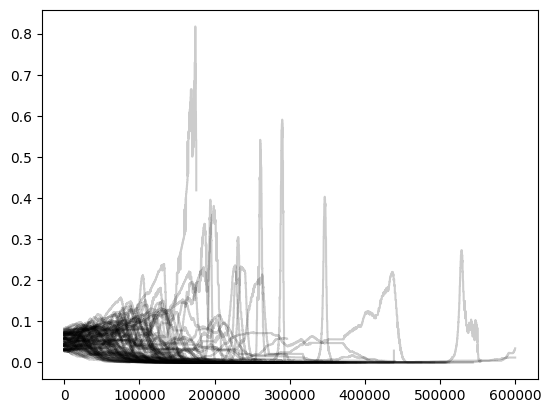

In [14]:
for trial, density_ts in density_ts_lookup.items():
    plt.plot(density_ts, color="black", alpha=0.2)
print(list(mean_densities_lookup.values()))
print(np.mean(list(mean_densities_lookup.values())))

In [18]:
dist_ts_lookup = {}
mean_dist_to_target_lookup = {}
for trial, data in trial_data.items():
    if termination_index_lookup[trial] is not None:
        data = data[: termination_index_lookup[trial]]
    offset_from_source = np.array(data) - np.array(([10, 80]))
    dist_ts_lookup[trial] = np.linalg.norm(offset_from_source, axis=1)
    mean_dist_to_target_lookup[trial] = dist_ts_lookup[trial].mean()
mean_dist_vec = np.array(list(mean_dist_to_target_lookup.values()))

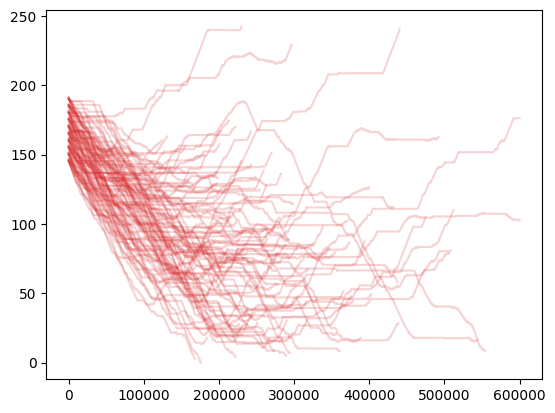

In [20]:
for trial, density_ts in dist_ts_lookup.items():
    plt.plot(density_ts, color="tab:red", alpha=0.2)

In [17]:
print(mean_dist_vec.mean(), mean_dist_vec.std())

106.68909469800764 29.57298673982862


Text(0, 0.5, 'y (mm)')

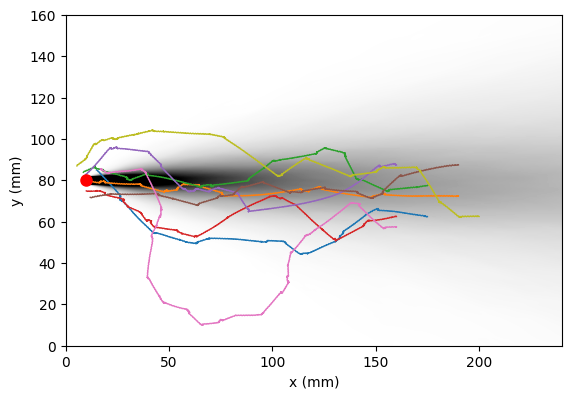

In [11]:
plt.imshow(
    mean_plume_intensity,
    extent=[0, 240, 0, 160],
    origin="lower",
    cmap="gray_r",
    vmin=0,
    vmax=0.2,
)
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#bcbd22",
    "#17becf",
]
color_counter = 0
for trial, termination_index in termination_index_lookup.items():
    if termination_index is None:
        continue
    xy = np.array(trial_data[trial][:termination_index])
    color = colors[color_counter % len(colors)]
    plt.plot(xy[:, 0], xy[:, 1], color=color, alpha=1, lw=1)
    color_counter += 1
plt.plot([10], [80], color="red", marker="o", markersize=8)
# plt.plot([10, 10, 30, 30, 10], [60, 100, 100, 60, 60], color="red", lw=1)
plt.xlim(0, 240)
plt.ylim(0, 160)
plt.gca().set_aspect("equal")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

In [12]:
sim_lengths = (
    np.array([x for x in termination_index_lookup.values() if x is not None]) * 1e-4
)
print(sim_lengths.mean(), sim_lengths.std())
print(sim_lengths)

29.227700000000002 11.58635031470221
[29.4494 17.5661 22.2179 28.9653 16.8139 27.3538 55.3866 36.0686]
